In [1]:
#1 Import Packages

In [16]:
import tensorflow as tf
import innvestigate
import numpy as np
import keras
import xarray as xr
import matplotlib.pyplot as plt

In [17]:
keras.__version__

'2.4.3'

#2 Load Data

In [18]:
data_input = xr.load_dataarray("../data/input_data_2.nc")

In [19]:
data_output = xr.load_dataarray("../data/output_data_2.nc")

In [20]:
data_input_sel = data_input.isel(sample = np.random.randint(9*10**3,10**4,10)).stack(feature=("lat","lon"))

#2 Load Model

In [21]:
model =tf.keras.models.load_model("../data/model_3/")

# 3 LRP

In [44]:
method_list = ["lrp.z","lrp.epsilon","lrp.alpha_1_beta_0","lrp.z_IB","lrp.epsilon_IB","lrp.alpha_1_beta_0_IB"]

In [45]:
data_input_sel = data_input.isel(sample = np.random.randint(9*10**3,10**4,10)).stack(feature=("lat","lon"))

In [46]:
arr = []
for method in method_list:
    analyzer = innvestigate.create_analyzer(method,model)
    analysis = analyzer.analyze(data_input_sel.values)
    analysis = xr.DataArray(analysis["input_1"], dims = ["sample", "feature"], coords = {"feature": data_input_sel.coords["feature"], "sample":data_input_sel.coords["sample"]})
    arr.append(analysis.assign_coords(intmethod=method))

In [47]:
analysis = xr.concat(arr, dim="intmethod")

In [48]:
n_methods = analysis.sizes["intmethod"]
n_sample = analysis.sizes["sample"]


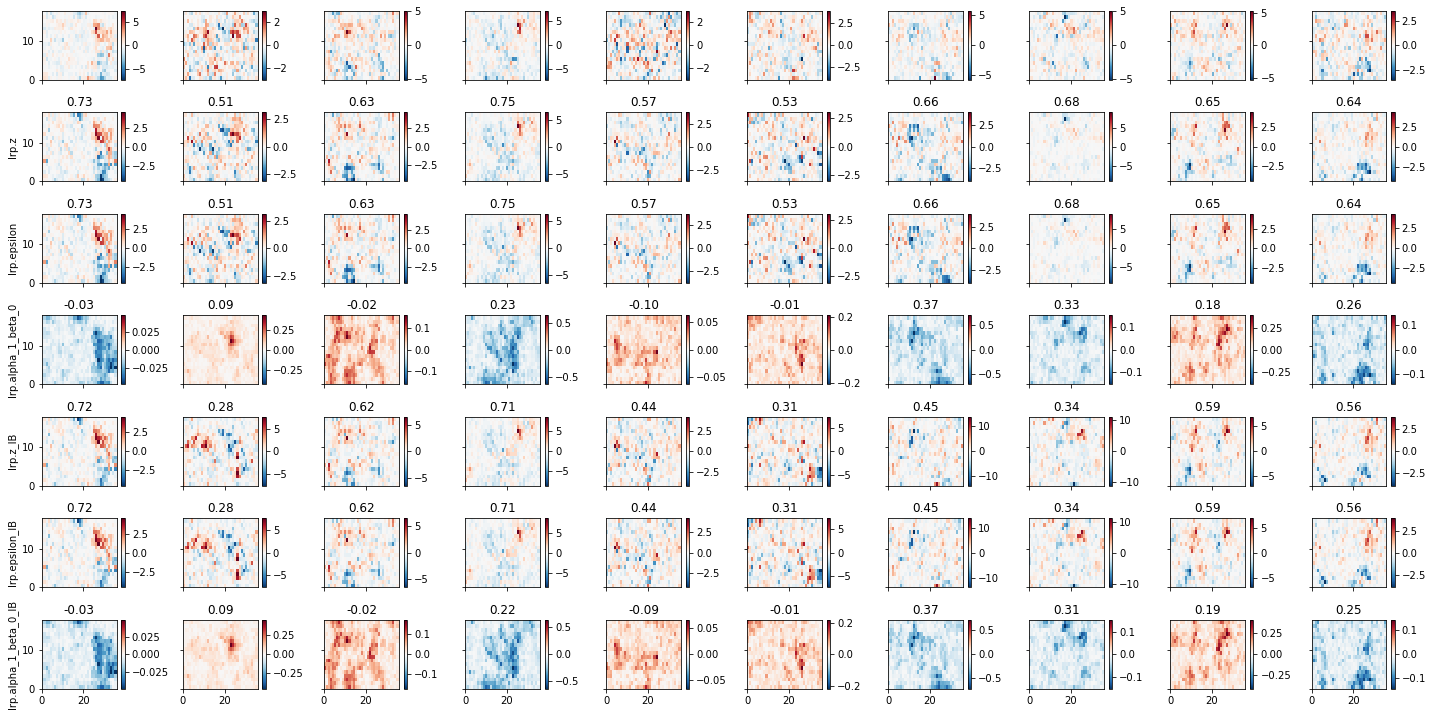

In [50]:
fig, ax = plt.subplots(n_methods+1,10,figsize=(20,10),sharex=True, sharey=True)

for sample_index, sample in enumerate(data_input_sel.coords["sample"]):
    tmp = data_output.sel(sample = sample)

    maximum = np.abs(tmp).max()

    plot = ax[0,sample_index].pcolormesh(tmp, vmin=-maximum, vmax=maximum, cmap ="RdBu_r")
    plt.colorbar(plot, ax = ax[0,sample_index])

    for method_index, method in enumerate(method_list):
        ana = analysis.sel(intmethod=method).sel(sample = sample).unstack()
        maximum = np.abs(ana).max()

        plot = ax[method_index+1,sample_index].pcolormesh(ana, vmin=-maximum, vmax=maximum, cmap ="RdBu_r")
        plt.colorbar(plot, ax = ax[method_index+1,sample_index])
        correlation = np.corrcoef(ana.values.flatten(), tmp.values.flatten())[0,1]
        
        ax[method_index+1,sample_index].set_title("{:.2f}".format(correlation))
        ax[method_index+1,0].set_ylabel(method)

plt.tight_layout()

plt.savefig("Comparison.png",dpi=300)

In [31]:
ana.values.sum()

-64.22484